# Carga de datos

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from xgboost import XGBRegressor
import os
import sys

sys.path.append(os.path.join(os.getcwd(), '..'))  # Para importar desde utils/
from utils.data_loader import cargar_datos_ventas

In [2]:
df = cargar_datos_ventas()

# Esquema para el modelo

## Elaboración de DataFrame con base semanal

El modelo será diseñado para el top 5 de productos más vendidos

In [3]:
# Identificamos top 5 productos por ventas
top5_productos = (
    df.groupby('nombre_producto', observed=True)['unidades_vendidas']
    .sum()
    .sort_values(ascending=False)
    .head(5)
    .index
    .tolist()
)

In [4]:
# Filtramos el DataFrame para incluir solo los productos del top 5
df_filtrado = df[df['nombre_producto'].isin(top5_productos)]


In [5]:
# Trabajaremos por semana para evitar ruido en el modelo
df_semana = (
    df_filtrado
    .assign(semana=lambda d: d['fecha'].dt.to_period('W').apply(lambda r: r.start_time))
    .groupby(['semana', 'sucursal', 'producto_id', 'nombre_producto'], observed=True)
    .agg(
        unidades_vendidas=('unidades_vendidas', 'sum'),
        precio_promedio=('precio_venta', 'mean'),
        en_promocion=('producto_en_promocion', 'max')
    )
    .reset_index()
)


## Construcción de variables para el modelo

In [6]:
# Aseguramos que esté en orden de producto, sucursal y semana
df_semana = df_semana.sort_values(['producto_id', 'sucursal', 'semana'])


In [7]:
# Ventas semana anterior
df_semana['ventas_semana_anterior'] = (
    df_semana
    .groupby(['producto_id', 'sucursal'], observed=True)['unidades_vendidas']
    .shift(1)
)

In [8]:
# Ventas ultimas 4 semanas
df_semana['promedio_ultimas_4_semanas'] = (
    df_semana
    .groupby(['producto_id', 'sucursal'], observed=True)['unidades_vendidas']
    .rolling(window=4, min_periods=1)
    .mean()
    .shift(1)
    .reset_index(level=[0,1], drop=True)
)

In [9]:
# Precio medio del producto en la semana
precio_medio_producto = df_semana.groupby('producto_id', observed=True)['precio_promedio'].transform('mean')
df_semana['precio_vs_medio_producto'] = df_semana['precio_promedio'] / precio_medio_producto


In [10]:
# Variables de calendario
df_semana['semana_del_año'] = df_semana['semana'].dt.isocalendar().week
df_semana['mes'] = df_semana['semana'].dt.month


## DataFrame para el modelo

### Validación de datos nulos

In [11]:
df_semana[['ventas_semana_anterior', 'promedio_ultimas_4_semanas', 'precio_vs_medio_producto']].isna().sum()


ventas_semana_anterior        20
promedio_ultimas_4_semanas     1
precio_vs_medio_producto       0
dtype: int64

In [12]:
# Eliminamos filas con NaN en las variables de interés
df_semana_notnull = df_semana.dropna(subset=[
    'ventas_semana_anterior',
    'promedio_ultimas_4_semanas'
])


### Validación de Outliers

In [13]:
df_semana_notnull[['ventas_semana_anterior', 'promedio_ultimas_4_semanas', 'precio_vs_medio_producto']].describe()


,ventas_semana_anterior,promedio_ultimas_4_semanas,precio_vs_medio_producto
count,2520.000000,2520.000000,2520.000000
mean,0.400794,0.400794,1.007936
std,3.768046,1.851761,9.434474
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000
max,48.000000,12.000000,140.950668


In [14]:
# Calculamos el IQR usando solo filas con ventas > 0
ventas_positivas = df_semana_notnull[df_semana_notnull['unidades_vendidas'] > 0]
q1 = ventas_positivas['precio_vs_medio_producto'].quantile(0.25)
q3 = ventas_positivas['precio_vs_medio_producto'].quantile(0.75)
iqr = q3 - q1

# Aplicamos el filtro sobre todo el dataset
df_no_outliers = df_semana_notnull[
    df_semana_notnull['precio_vs_medio_producto'].between(q1 - 1.5 * iqr, q3 + 1.5 * iqr)
].copy()


### DataFrame final

In [15]:
df_modelo = df_no_outliers.copy()

#### Breve verificación del DataFrame tras el tratamiento de nulls y outliers

In [16]:
print(f"Número total de filas de df_semana: {len(df_semana)}")

print(f"Número total de filas de df_modelo: {len(df_modelo)}")

print(f"Diferencia de filas: {len(df_semana) - len(df_modelo)}")


Número total de filas de df_semana: 2540
Número total de filas de df_modelo: 30
Diferencia de filas: 2510


In [17]:
print("Productos únicos:", df_modelo['producto_id'].nunique())
print("Sucursales únicas:", df_modelo['sucursal'].nunique())


Productos únicos: 5
Sucursales únicas: 4


In [18]:
df_modelo['unidades_vendidas'].describe()


count    30.000000
mean     31.566667
std      12.158957
min       8.000000
25%      20.750000
50%      34.000000
75%      42.500000
max      48.000000
Name: unidades_vendidas, dtype: float64

# Entrenamiento de modelos

## Prelims

### 1. División de datos: entrenamiento y prueba

In [19]:
# División en series de tiempo (se usa el 60% en vez del 80% para evitar que el test sea muy pequeño, dada la poca cantidad de datos)
# Fecha límite para división: 60% más antigua -> train, 40% más reciente -> test
fecha_split = df_modelo['semana'].sort_values().quantile(0.6)

df_train = df_modelo[df_modelo['semana'] <= fecha_split]
df_test  = df_modelo[df_modelo['semana'] > fecha_split]


### 2. Selección de variables (X) y objetivo (y)

In [20]:
features = [
    'ventas_semana_anterior',
    'promedio_ultimas_4_semanas',
    'precio_vs_medio_producto',
    'en_promocion',
    'semana_del_año',
    'mes'
]

X_train = df_train[features]
y_train = df_train['unidades_vendidas']

X_test = df_test[features]
y_test = df_test['unidades_vendidas']


## Modelos

### 1. DecisionTree

#### Modelo

In [21]:
# Entrenamiento
tree_model = DecisionTreeRegressor(max_depth=5, random_state=42)
tree_model.fit(X_train, y_train)


,criterion,'squared_error'
,splitter,'best'
,max_depth,5
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,42
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,ccp_alpha,0.0


In [22]:
# Prediccion
y_pred_tree = tree_model.predict(X_test)


In [23]:
# Evaluación
mae_tree = mean_absolute_error(y_test, y_pred_tree)
rmse_tree = np.sqrt(mean_squared_error(y_test, y_pred_tree))


#### Resultados

In [24]:

print(f'[Decision Tree] Número de filas en el conjunto de entrenamiento: {len(X_train)}')
print(f'[Decision Tree] MAE: {mae_tree:.2f}')
print(f'[Decision Tree] RMSE: {rmse_tree:.2f}')


[Decision Tree] Número de filas en el conjunto de entrenamiento: 18
[Decision Tree] MAE: 15.33
[Decision Tree] RMSE: 20.17


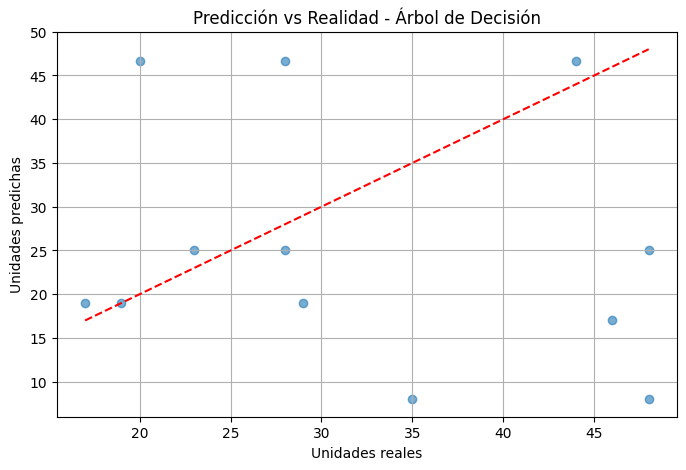

In [25]:
plt.figure(figsize=(8, 5))
plt.scatter(y_test, y_pred_tree, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Unidades reales')
plt.ylabel('Unidades predichas')
plt.title('Predicción vs Realidad - Árbol de Decisión')
plt.grid(True)
plt.show()


In [ ]:
# Importancia de las características
importancia_tree = pd.DataFrame({
    'variable': X_train.columns,
    'importancia': tree_model.feature_importances_
}).sort_values(by='importancia', ascending=False)

print(importancia_tree)


                     variable  importancia
2    precio_vs_medio_producto     0.473322
4              semana_del_año     0.293639
5                         mes     0.233039
0      ventas_semana_anterior     0.000000
1  promedio_ultimas_4_semanas     0.000000
3                en_promocion     0.000000


#### Análisis

El modelo de árbol de decisión entrenado presenta un **MAE de 15.33** y un **RMSE de 20.17**, lo cual indica un error promedio considerable al predecir la demanda semanal. Al analizar la gráfica de predicción vs. realidad, se evidencia una alta dispersión respecto a la línea ideal, con casos de **subestimación y sobreestimación severas**.

Además, el análisis de importancia de variables revela que el modelo se apoya principalmente en el precio_vs_medio_producto y variables de calendario (semana_del_año, mes), pero **ignora completamente** variables clave como ventas_semana_anterior, promedio_ultimas_4_semanas y en_promocion. Este patrón sugiere que el árbol no logró capturar adecuadamente la **dependencia temporal ni la influencia promocional**, probablemente por la poca cantidad de datos y la naturaleza limitada del algoritmo.

En resumen, este modelo base ofrece una primera aproximación útil, pero **no generaliza bien** y no logra explotar adecuadamente las variables históricas más relevantes para la predicción de demanda. Se recomienda probar un modelo más robusto como **Random Forest** para mejorar la estabilidad y capacidad predictiva.

### 2. RandomForest

#### Modelo

In [27]:
# Entrenamiento
rf_model = RandomForestRegressor(
    n_estimators=1000,
    max_depth=10,
    random_state=42,
    n_jobs=-1
)
rf_model.fit(X_train, y_train)


,n_estimators,1000
,criterion,'squared_error'
,max_depth,10
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [28]:
# Predicción
y_pred_rf = rf_model.predict(X_test)


In [29]:
# Evaluación
mae_rf = mean_absolute_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))


#### Resultados

In [30]:
print(f'[Random Forest] Número de filas en el conjunto de entrenamiento: {len(X_train)}')
print(f'[Random Forest] MAE: {mae_rf:.2f}')
print(f'[Random Forest] RMSE: {rmse_rf:.2f}')

[Random Forest] Número de filas en el conjunto de entrenamiento: 18
[Random Forest] MAE: 14.67
[Random Forest] RMSE: 17.19


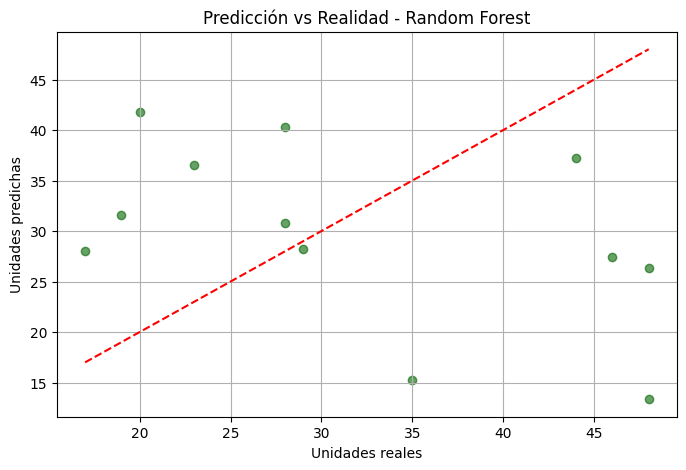

In [31]:
plt.figure(figsize=(8, 5))
plt.scatter(y_test, y_pred_rf, alpha=0.6, color='darkgreen')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Unidades reales')
plt.ylabel('Unidades predichas')
plt.title('Predicción vs Realidad - Random Forest')
plt.grid(True)
plt.show()

In [32]:
importancia_rf = pd.DataFrame({
    'variable': X_train.columns,
    'importancia': rf_model.feature_importances_
}).sort_values(by='importancia', ascending=False)

print(importancia_rf)

                     variable  importancia
2    precio_vs_medio_producto     0.512746
4              semana_del_año     0.264518
5                         mes     0.208076
1  promedio_ultimas_4_semanas     0.014660
0      ventas_semana_anterior     0.000000
3                en_promocion     0.000000


#### Análisis

El modelo de **Random Forest** entrenado presenta un **MAE de 14.67** y un **RMSE de 17.19**, lo que representa una mejora leve frente al árbol de decisión, aunque sigue reflejando un error considerable en la predicción semanal de la demanda. La gráfica de predicción vs. realidad muestra una dispersión significativa, con tendencia a **subestimar las ventas altas y sobreestimar las bajas**, lo cual indica que el modelo tiende a suavizar los extremos.

El análisis de importancia de variables revela que el modelo se apoya principalmente en `precio_vs_medio_producto` y variables de calendario (`semana_del_año`, `mes`), mientras que variables clave como `ventas_semana_anterior`, `promedio_ultimas_4_semanas` y `en_promocion` tienen **poca o nula relevancia** en la predicción. Esto sugiere que el modelo no logró aprovechar del todo la **información histórica ni los efectos de promociones**, probablemente debido a la **escasez de datos y la limitada variabilidad temporal**.

En resumen, aunque Random Forest mejora levemente el desempeño y estabilidad frente al modelo anterior, **su capacidad predictiva sigue siendo limitada**. La incorporación de más datos históricos y la exploración de modelos como **XGBoost** podrían ofrecer mejores resultados en escenarios reales de planificación de demanda.


### 3. XGBoost

#### Typecasting para trabajar con XGBoost

In [33]:
# Convertimos X y y a float32
X_train_xgb = X_train.astype('float32')
X_test_xgb = X_test.astype('float32')
y_train_xgb = y_train.astype('float32')
y_test_xgb = y_test.astype('float32')

#### Modelo

In [ ]:
# Entrenamiento
xgb_model = XGBRegressor(
    n_estimators=1000,
    max_depth=5,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)
xgb_model.fit(X_train_xgb, y_train)


,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [55]:

# Predicción
y_pred_xgb = xgb_model.predict(X_test_xgb)


In [56]:

# Evaluación
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))


#### Resultados

In [58]:
print(f'[XGBoost] Número de filas en el conjunto de entrenamiento: {len(X_train_xgb)}')
print(f'[XGBoost] MAE: {mae_xgb:.2f}')
print(f'[XGBoost] RMSE: {rmse_xgb:.2f}')


[XGBoost] Número de filas en el conjunto de entrenamiento: 18
[XGBoost] MAE: 16.78
[XGBoost] RMSE: 20.19


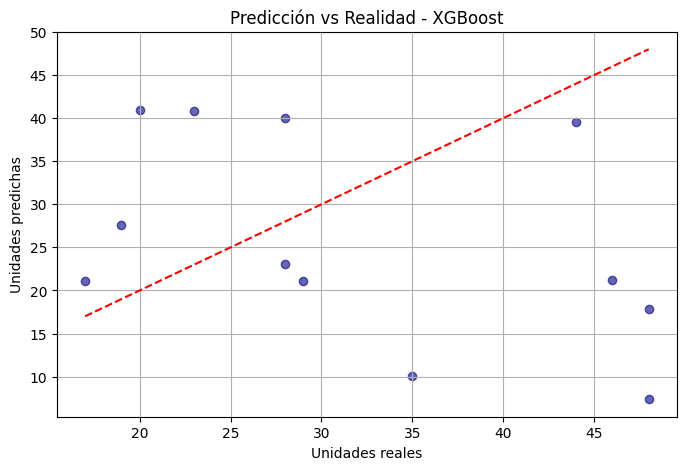

In [59]:
plt.figure(figsize=(8, 5))
plt.scatter(y_test, y_pred_xgb, alpha=0.6, color='navy')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Unidades reales')
plt.ylabel('Unidades predichas')
plt.title('Predicción vs Realidad - XGBoost')
plt.grid(True)
plt.show()


In [60]:
importancia_xgb = pd.DataFrame({
    'variable': X_train.columns,
    'importancia': xgb_model.feature_importances_
}).sort_values(by='importancia', ascending=False)

print(importancia_xgb)

                     variable  importancia
4              semana_del_año     0.415359
2    precio_vs_medio_producto     0.224112
5                         mes     0.183770
1  promedio_ultimas_4_semanas     0.176759
0      ventas_semana_anterior     0.000000
3                en_promocion     0.000000


#### Análisis

El modelo XGBoost entrenado obtuvo un **MAE de 16.78** y un **RMSE de 20.19**, resultados similares a los modelos anteriores. La gráfica de predicción vs. realidad muestra una alta dispersión y tendencia a **sobreestimar valores bajos y subestimar valores altos**, indicando una dificultad para capturar la amplitud real de la demanda.

En cuanto a importancia de variables, XGBoost priorizó elementos de **estacionalidad** (`semana_del_año`, `mes`) y el `precio_vs_medio_producto`, relegando por completo a `ventas_semana_anterior` y `en_promocion`. Esto sugiere que el modelo depende más de patrones cíclicos y variaciones de precio que de la información temporal directa o eventos promocionales, posiblemente debido al **tamaño reducido y limitada variabilidad del conjunto de entrenamiento**.